# Crear y explorar environment de space invaders
---


In [1]:
#Ajustamos tensorflow a una versión compatible
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.

In [2]:
#Instalamos las librerías para crear y explorar el environment
!pip install keras-rl2==1.0.5 gym[atari] autorom[accept-rom-license]
#keras-rl2 nos va a permitir tener mejor red neuronal
#gym va a permitir coger el juego de space invaders y entrenarlo
#autorom acepta acuerdos de licencias

INFO: pip is looking at multiple versions of gym[atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 32.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.7 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446709 sha256=6a78d5aa5dec2573375521658e95e8fe3aa08849cd7f80cb16c3041375b7d928
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d

In [3]:
import numpy as np, tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D

#Para el entrenamiento concreto
from rl.agents import DQNAgent
#Memoria para guardar las imágenes
from rl.memory import SequentialMemory
#Política para aprendizaje epsilon
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
#Cada vez que termine un step (epoca) se devuelve un callback (función)
from rl.callbacks import ModelIntervalCheckpoint
#Para procesar más facilmente la red neuronal
from rl.core import Processor

In [4]:
try:
    import gymnasium as gym
except ImportError:
    import gym

class GymV21Compat(gym.Wrapper):
    def reset(self, **kwargs):
        out = self.env.reset(**kwargs)
        # Gymnasium devuelve (obs, info); keras-rl2 espera solo obs
        if isinstance(out, tuple) and len(out) == 2:
            obs, info = out
            return obs
        return out

    def step(self, action):
        out = self.env.step(action)
        # Gymnasium devuelve (obs, reward, terminated, truncated, info)
        if isinstance(out, tuple) and len(out) == 5:
            obs, reward, terminated, truncated, info = out
            done = terminated or truncated
            return obs, reward, done, info
        return out

env = gym.make("ALE/SpaceInvaders-v5", render_mode=None, frameskip=4, repeat_action_probability=0.25)
env = GymV21Compat(env)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
#Sacamos el tamaño de la imagen de observación que es de 210x160x3 siendo 3 canales (RGB)
height, width, channels = env.observation_space.shape
env.observation_space.shape

(210, 160, 3)

In [6]:
#Obtenemos las posibles acciones que puede hacer el agente
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [7]:
#Devuelve el número de acciones posibles
actions = env.action_space.n
actions

6

In [8]:
#Resetea el entorno y retorna una imagen
env.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

In [9]:
#Recibe el índice de la acción que va a tomar
state_next, reward, done, info = env.step(0)
'''
state_next: devuelve el nuevo estado tras hacer esa acción
reward: la recompensa comienza en 0.0 y sube si le damos recompensa.
done: indica si se ha acabado el episodio
info: informa acerca de como va la partida (no se suele usar)
'''

'\nstate_next: devuelve el nuevo estado tras hacer esa acción\nreward: la recompensa comienza en 0.0 y sube si le damos recompensa.\ndone: indica si se ha acabado el episodio\ninfo: informa acerca de como va la partida (no se suele usar)\n'

In [10]:
import matplotlib.pyplot as plt

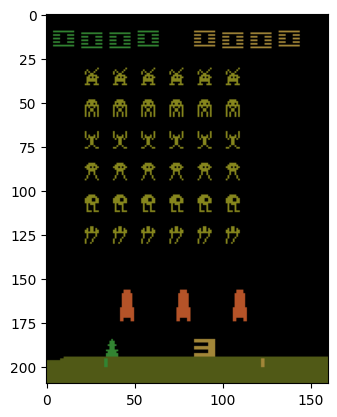

In [11]:
#Mostramos cual va a ser el estado siguiente en el juego
plt.imshow(state_next)

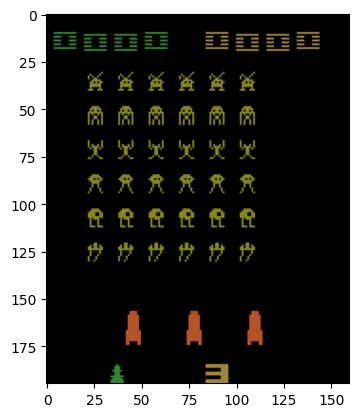

In [12]:
#Quitamos la parte del suelo que no se mueve y así hay menos imagen que procesar
plt.imshow(state_next[0:195,:,:])

# Crear modelo CNN + RL
---

In [13]:
#Hacemos una función para definir la CNN
def buildModel():
    #Inicializamos la red neuronal
    model = Sequential()
    #Añadimos la convolución y hacemos 32 convoluciones de 8x8 y se va a mover de 4 en 4
    #El input_shape toma 4 imágenes de 84x84 y toma 1 canal
    model.add(Conv2D(32, (8,8), strides = (4,4), activation = 'relu', input_shape = (4,84,84,1)))
    #Añadimos otra convolución y hacemos 64 convoluciones de 4x4 y se va a mover de 2 en 2
    model.add(Conv2D(64, (4,4), strides = (2,2), activation = 'relu'))
    #Añadimos otra convolución sin solapamiento de unas imágenes con otras
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    #Añadimos Flatten
    model.add(Flatten())
    #Capas de neuronas
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    #Devuelve 6 acciones y devuelve una regresión lineal (linear)
    model.add(Dense(actions, activation = 'linear'))
    return model

In [14]:
#Instanciamos el modelo
model = buildModel()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 20, 20, 32)     2080      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 9, 9, 64)       32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 7, 7, 64)       36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 512)               6423040   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 6)                 1

In [16]:
#Para procesar solo lo que nos interesa preprocesamos las imágenes
import cv2
def process_img(observation):
    if isinstance(observation, tuple):
        observation = observation[0]
    img = observation.copy()
    img = img[0:195, :, :]
    img = cv2.resize(img, (84,84))
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.expand_dims(img_gray, axis = 2)/ 255 #Nos queda una imagen entre 0 y 1

In [17]:
#Sobreescribimos la clase del juego para
class AtariProcessor(Processor):
    #Poder cambiar como procesa las imágenes
    def process_observation(self, observation):
        if isinstance(observation, tuple):
            observation = observation[0]
        return process_img(observation)
    #Poder cambiar como procesa las recompensas
    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [18]:
#Inicializamos el processor
processor = AtariProcessor()

In [19]:
#Construye el agente dado el modelo y unas acciones
def buildAgent(model, actions):
    #Hace que el epsilon vaya bajando de forma lineal conforme pasen los steps
    #Controla como el agente elige acciones al azar o por lo aprendido
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr = 'eps', #Usa epsilon
        value_max = 1.0, #Comienza epsilon en el 100% de aleatoriedad
        value_min = 0.5, #Termina epsilon en el 50% de aleatoriedad y otro 50% de lo que ha aprendido
        value_test = 0.2, #Para hacer la prueba con un 20% de aleatoriedad
        nb_steps = 40000 #Los pasos que va a hacer
    )
    #Inicializa la memoria
    #Guarda las transiciones (acción, estado, recompensa y siguiente estado)
    memory = SequentialMemory(
        limit = 10000, #Solo conserva las últimas 10 000 experiencias (se sobreescriben las viejas)
        window_length = 4 #Agrupa 4 frames seguidos como entrada a la red (útil para juegos Atari)
    )
    #Crea el agente Deep-Q-Network
    dqn = DQNAgent(
        model = model, #La CNN que mide los valores Q(s,a)
        memory = memory, #La memoria
        processor = processor, #El procesador
        policy = policy, #La política de decrecimiento de epsilon
        enable_dueling_network = True, #Separa la estimación del estado y la ventaja de cada acción
        nb_actions = actions, #Número de acciones discretas que puede tomar el agente
        nb_steps_warmup = 1000 #Durante los 1000 primeros pasos el agente no entrena la red
        #Solo rellena la memoria con experiencias y elige acciones aleatorias
    )
    return dqn

In [20]:
#Instanciamos el agente y lo compilamos
dqn = buildAgent(model, actions)
dqn.compile(tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4), metrics = ['mae']) #1e-4 controla cuanto se actualizan los pesos
dqn.save_weights('dqn_weights_start')

In [26]:
#Definimos como se guardarán los estados de los steps en archivos
ckpt_filename = 'dqn_weights_{step}'
#Guarda el modelo después del paso 30000
callbacks = [ModelIntervalCheckpoint(ckpt_filename, interval = 30000)]

# Entrenamiento
---

In [27]:
#Entrenamos el modelo (dura bastante)
dqn.fit(
    env, #Entrena el agente en el entorno (el juego)
    callbacks = callbacks, #Añade los callbacks
    nb_steps = 40000, #Número de steps
    visualize = False, #No muestra el entorno (en kaggle no es posible)
    verbose = 1 #1 muestra una barra de progreso básica y 2 imprime más detalles
)

Training for 40000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 1941s 194ms/step - reward: 0.0195
18 episodes - episode_reward: 10.722 [2.000, 18.000] - loss: 0.004 - mae: 0.094 - mean_q: 0.174 - mean_eps: 0.931 - lives: 2.029 - episode_frame_number: 1188.758 - frame_number: 67457.919

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 2213s 221ms/step - reward: 0.0201
20 episodes - episode_reward: 9.900 [1.000, 19.000] - loss: 0.004 - mae: 0.159 - mean_q: 0.248 - mean_eps: 0.813 - lives: 2.046 - episode_frame_number: 1126.802 - frame_number: 107426.119

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 2327s 233ms/step - reward: 0.0187
19 episodes - episode_reward: 10.053 [1.000, 21.000] - loss: 0.003 - mae: 0.212 - mean_q: 0.307 - mean_eps: 0.688 - lives: 2.130 - episode_frame_number: 1180.152 - frame_number: 147390.483

Interval 4 (30000 steps performed)
10000/10000 [===========

In [28]:
#Guardamos los pesos
dqn.save_weights("dqn_weights_last")

[WARNING] dqn_weights_last.index already exists - overwrite? [y/n] y


[TIP] Next time specify overwrite=True!


# Evaluación
---

In [29]:
import glob

In [30]:
#Recorremos los checkpoints para compararlos
for ckpt in sorted(glob.glob("/kaggle/working/dqn_weights_*.index")):
    #Obtenemos siempre los archivos sin el .index o el .h5 del final
    ckpt = ckpt.split('.')[0]
    #Cargamos sus pesos
    dqn.load_weights(ckpt)
    print("------------{}------------".format(ckpt))
    #Testeamos con los distintos checkpoints
    scores = dqn.test(env, nb_episodes = 10, visualize = False)
    #Mostramos la recompensa por episodio y los steps tomados en cada uno
    print("mean reward: {} mean steps: {}".format(np.mean(scores.history['episode_reward']), np.mean(scores.history['nb_steps'])))

------------/kaggle/working/dqn_weights_30000------------
Testing for 10 episodes ...
Episode 1: reward: 14.000, steps: 735
Episode 2: reward: 7.000, steps: 300
Episode 3: reward: 19.000, steps: 761
Episode 4: reward: 8.000, steps: 369
Episode 5: reward: 14.000, steps: 620
Episode 6: reward: 11.000, steps: 517
Episode 7: reward: 10.000, steps: 524
Episode 8: reward: 8.000, steps: 499
Episode 9: reward: 4.000, steps: 290
Episode 10: reward: 18.000, steps: 777
mean reward: 11.3 mean steps: 539.2
------------/kaggle/working/dqn_weights_last------------
Testing for 10 episodes ...
Episode 1: reward: 13.000, steps: 636
Episode 2: reward: 4.000, steps: 502
Episode 3: reward: 6.000, steps: 290
Episode 4: reward: 18.000, steps: 941
Episode 5: reward: 12.000, steps: 584
Episode 6: reward: 4.000, steps: 424
Episode 7: reward: 12.000, steps: 530
Episode 8: reward: 7.000, steps: 513
Episode 9: reward: 18.000, steps: 874
Episode 10: reward: 18.000, steps: 903
mean reward: 11.2 mean steps: 619.7
---

# Visualización
---

In [31]:
#Ordenamos y metemos en un array todos los checkpoints
checkpoints = sorted(glob.glob("/kaggle/working/dqn_weights_*.index"))

In [32]:
#Para cada checkpoint
for ckpt in checkpoints:
    #Almacenaremos recompensas y frames
    rewards = []
    frames = []
    #Evaluamos ese checkpoint para 3 episodios
    for i in range(0,3):
        #Nos quedamos con el nombre sin la extensión del archivo
        ckpt = ckpt.split('.')[0]
        #Cargamos los pesos del checkpoint
        dqn.load_weights(ckpt)
        #Reseteamos el preparamos el estado inicial
        done = False
        #Iniciamos una nueva partida
        state = env.reset()
        #Replicamos el frame inicial 4 veces para llenar el window_length = 4 de la entrada
        state = [state]*4
        #Procesa los frames
        state = [process_img(i) for i in state]
        #Mientras no se haya terminado
        while not done:
            #Usamos la red para calcular los valores Q(s,a) y np.argmax elige la Q óptima
            action = np.argmax(dqn.compute_q_values(np.array(state)))
            #Ejecuta la acción en el entorno
            state_next, reward, done, info = env.step(action)
            #Elimina el frame más antiguo
            state.pop(0)
            #Añade el frame nuevo procesado
            state.append(process_img(state_next))
            #Guarda la recompensa del step
            rewards.append(reward)
            #Guarda el frame del video
            frames.append(state_next)
        #Después de cada episodio imprime la recompensa total acumulada y así mides el rendimiento del agente en ese checkpoint
        print("Recompensa para {} episodio {} es {}".format(ckpt, i+1, np.sum(rewards)))
    #Abre un archivo de video y guarda los frames uno tras otro en el archivo .mp4
    out = cv2.VideoWriter("{}.mp4".format(ckpt), cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),60,(width,height))
    for frame in frames:
        img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(img)
    print("Video para {} serializado".format(ckpt))
    out.release()

Recompensa para /kaggle/working/dqn_weights_30000 episodio 1 es 295.0
Recompensa para /kaggle/working/dqn_weights_30000 episodio 2 es 330.0
Recompensa para /kaggle/working/dqn_weights_30000 episodio 3 es 405.0
Video para /kaggle/working/dqn_weights_30000 serializado
Recompensa para /kaggle/working/dqn_weights_last episodio 1 es 205.0
Recompensa para /kaggle/working/dqn_weights_last episodio 2 es 280.0
Recompensa para /kaggle/working/dqn_weights_last episodio 3 es 520.0
Video para /kaggle/working/dqn_weights_last serializado
Recompensa para /kaggle/working/dqn_weights_start episodio 1 es 80.0
Recompensa para /kaggle/working/dqn_weights_start episodio 2 es 225.0
Recompensa para /kaggle/working/dqn_weights_start episodio 3 es 330.0
Video para /kaggle/working/dqn_weights_start serializado
